In [2]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib import colors
import glob
from land_wavelet import wclass
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from pyproj import CRS, Transformer

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
files = glob.glob('/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/MTG_VIS_tifs/FCI_tif_NRT/*.tif')

In [4]:
with open("/home/ck/DIR/cornkle/data/EUMDAC_MTG_TESTS/domain_tifs/crs_proj_geostationary_MTG.txt", "r") as f:
    crs = CRS.from_proj4(f.read())
def read_geotiff(file):
    data = rioxarray.open_rasterio(file)
    data_rio = data.rio.write_crs(crs)
    data_reprojected = data_rio.rio.reproject("EPSG:4326")

    data_reprojected = data_reprojected.sel(x=slice(13,36), y=slice(-9, -35))
    data_reprojected = data_reprojected.where(data_reprojected.values<60000, other=0)
    
    #data_reprojected = (data_reprojected - np.min(data_reprojected)) / (np.max(data_reprojected) - np.min(data_reprojected))
    #data = data.where((data>2) & (data<3))
    
    return data_reprojected.squeeze()

In [87]:
da_box = read_geotiff(files[250])

/home/ck/miniforge3/envs/general/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


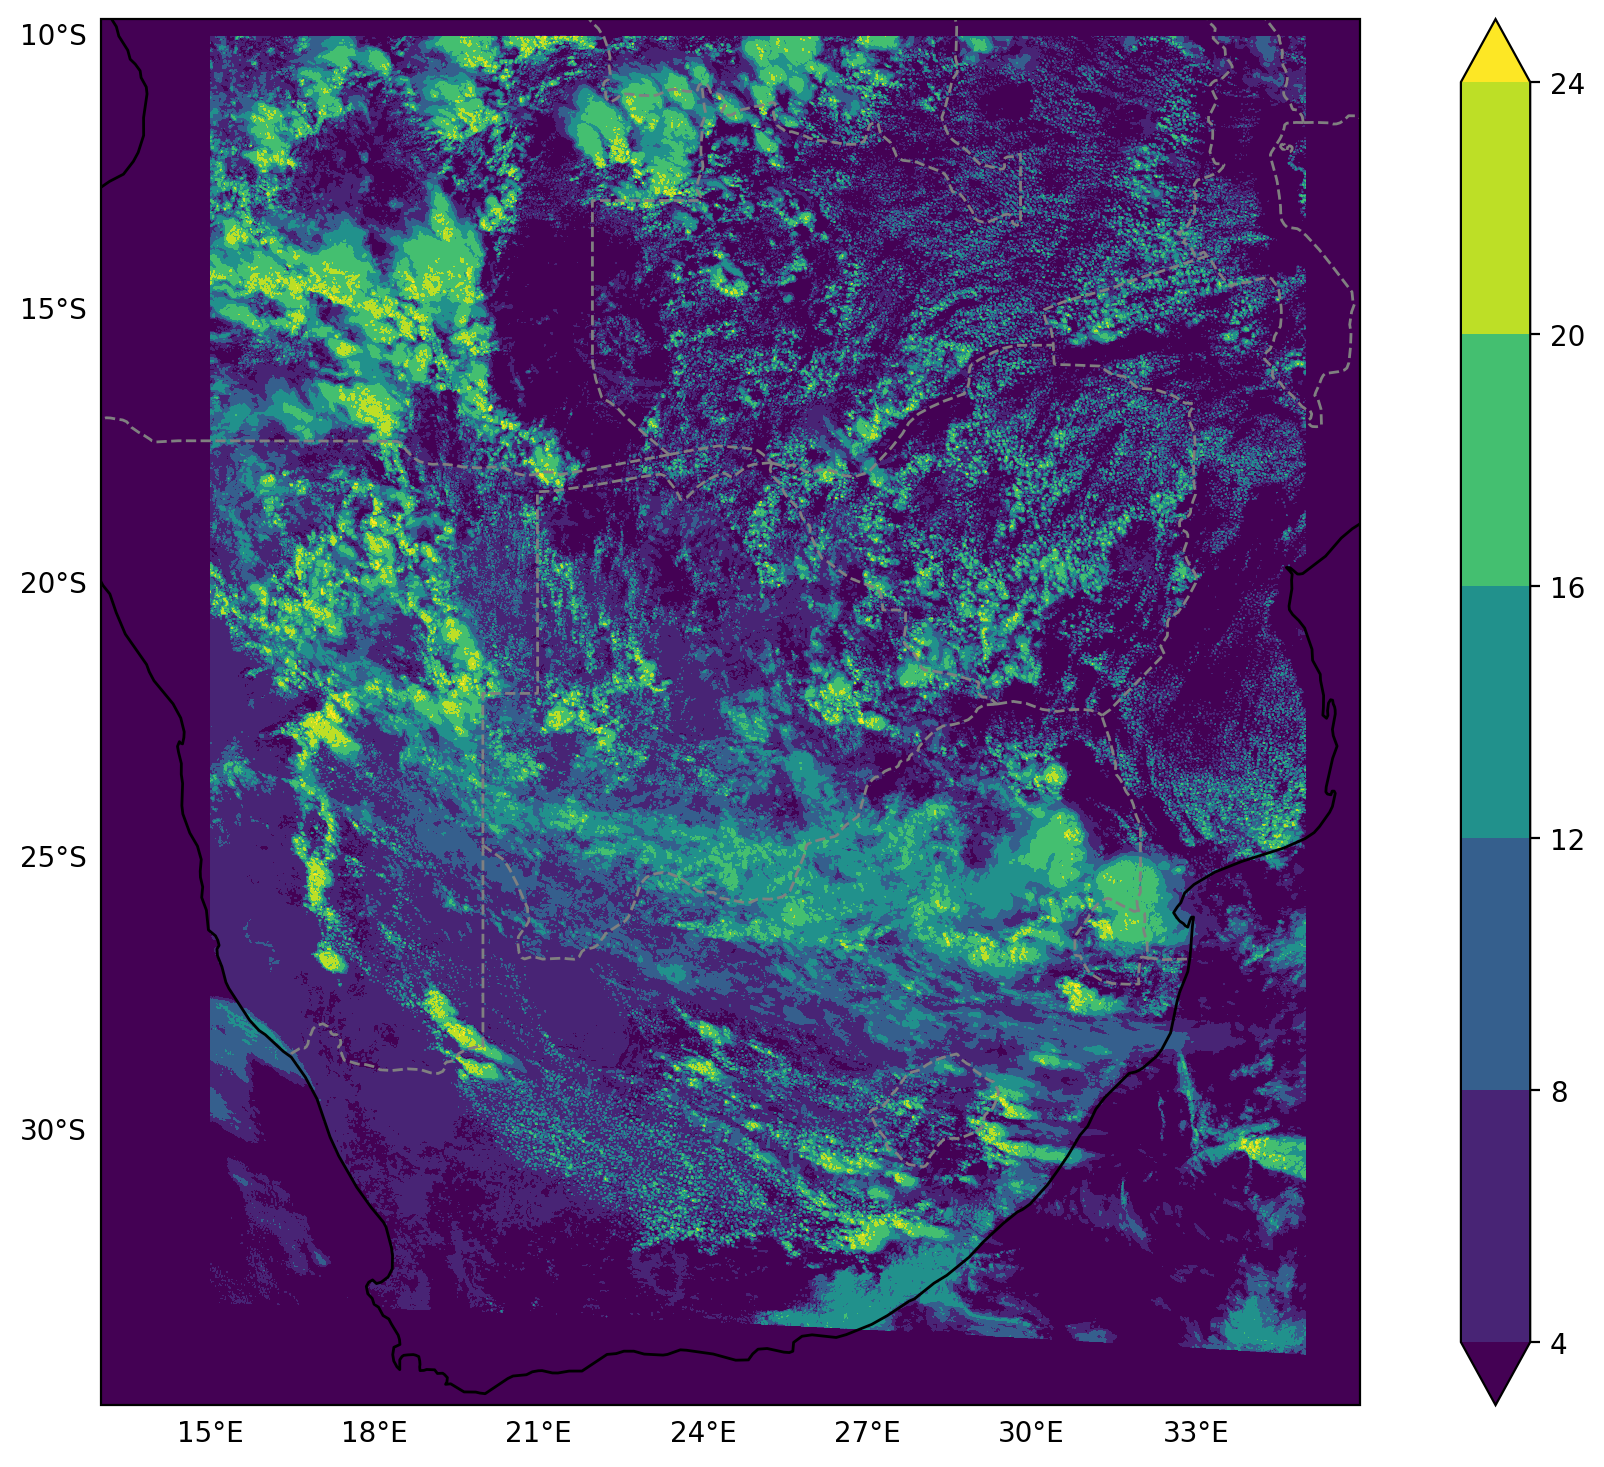

In [88]:
f = plt.figure(figsize=(13,9), dpi=200)
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
plt.contourf(da_box.x.values, da_box.y.values, da_box.where(da_box.values<60000, other=0).squeeze(), transform=ccrs.PlateCarree(), cmap='viridis', extend='both')
ax.coastlines()

xl = ax.gridlines(draw_labels=True);
xl.top_labels = False
xl.right_labels = False
xl.xlines = False
xl.ylines=False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');

cbar = plt.colorbar()


In [89]:
da_box = da_box.sel(y=slice(-15,-33), x=slice(18,28))

In [90]:
da_box

<xarray.DataArray (y: 2580, x: 1433)> Size: 15MB
array([[19.646185 , 19.298403 , 18.666716 , ...,  2.2215528,  2.2925289,
         2.129284 ],
       [19.504232 , 18.936424 , 18.113102 , ...,  2.0512102,  2.2144551,
         2.1718695],
       [19.561014 , 19.291304 , 19.610697 , ...,  2.1931624,  1.8737699,
         2.129284 ],
       ...,
       [ 2.8319473,  2.9029233,  2.7964592, ..., 10.539951 , 11.2852   ,
        12.0801325],
       [ 2.689995 ,  2.6474094,  2.6828973, ..., 10.554147 , 11.6116905,
        12.470501 ],
       [ 2.4060907,  2.654507 ,  2.7112877, ..., 10.689001 , 11.043881 ,
        12.463404 ]], shape=(2580, 1433), dtype=float32)
Coordinates:
  * x            (x) float64 11kB 18.0 18.01 18.02 18.02 ... 27.98 27.99 27.99
  * y            (y) float64 21kB -15.01 -15.01 -15.02 ... -32.99 -32.99 -33.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:        Area
    ancillary_variables:  pixel_quality
    coordinates:          y x
    description:          VIS 0.6 HR Effective radiance
    long_name:            VIS 0.6 HR Effective radiance
    unit:                 mW.m-2.sr-1.(cm-1)-1
    ...                   ...
    valid_range:          [0, 4095]
    warm_add_offset:      0
    warm_scale_factor:    0
    scale_factor:         1.0
    add_offset:           0.0
    _FillValue:           65535.0

In [91]:
### Create a wavelet decomposition object first. In this example, we initialise the SM5k 5km setup. The setups can be defined in land_wavelet.constants
wObj = wclass.landwav('VIS_05')

Initialised wavelet with scales:  [ 1.5         1.97926187  2.61165169  3.44609506  4.5471497   6.
  7.91704746 10.44660676 13.78438026 18.1885988  24.         31.66818986
 41.78642704 55.13752104 72.75439519 96.        ]


In [92]:
wObj.scales[8]

np.float64(13.784380259964422)

In [93]:
### The next step prepares the SM image for the wavelet routine. NaNs are removed by filling in zeros that can be masked again after wavelet application.
wObj.read_img(da_box.values, np.arange(0,da_box.shape[0],0.5), np.arange(0,da_box.shape[1],0.5))

In [94]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers could be used for diverse analyses.

coeffs, power, scales, period = wObj.applyWavelet(normed='stddev', ge_thresh=None, le_thresh=0, fill=0.01)

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: stddev Please note: Choose none if value reconstruction is intended.


Text(0.5, 1.0, '96.0 km scale wavelet coefficients')

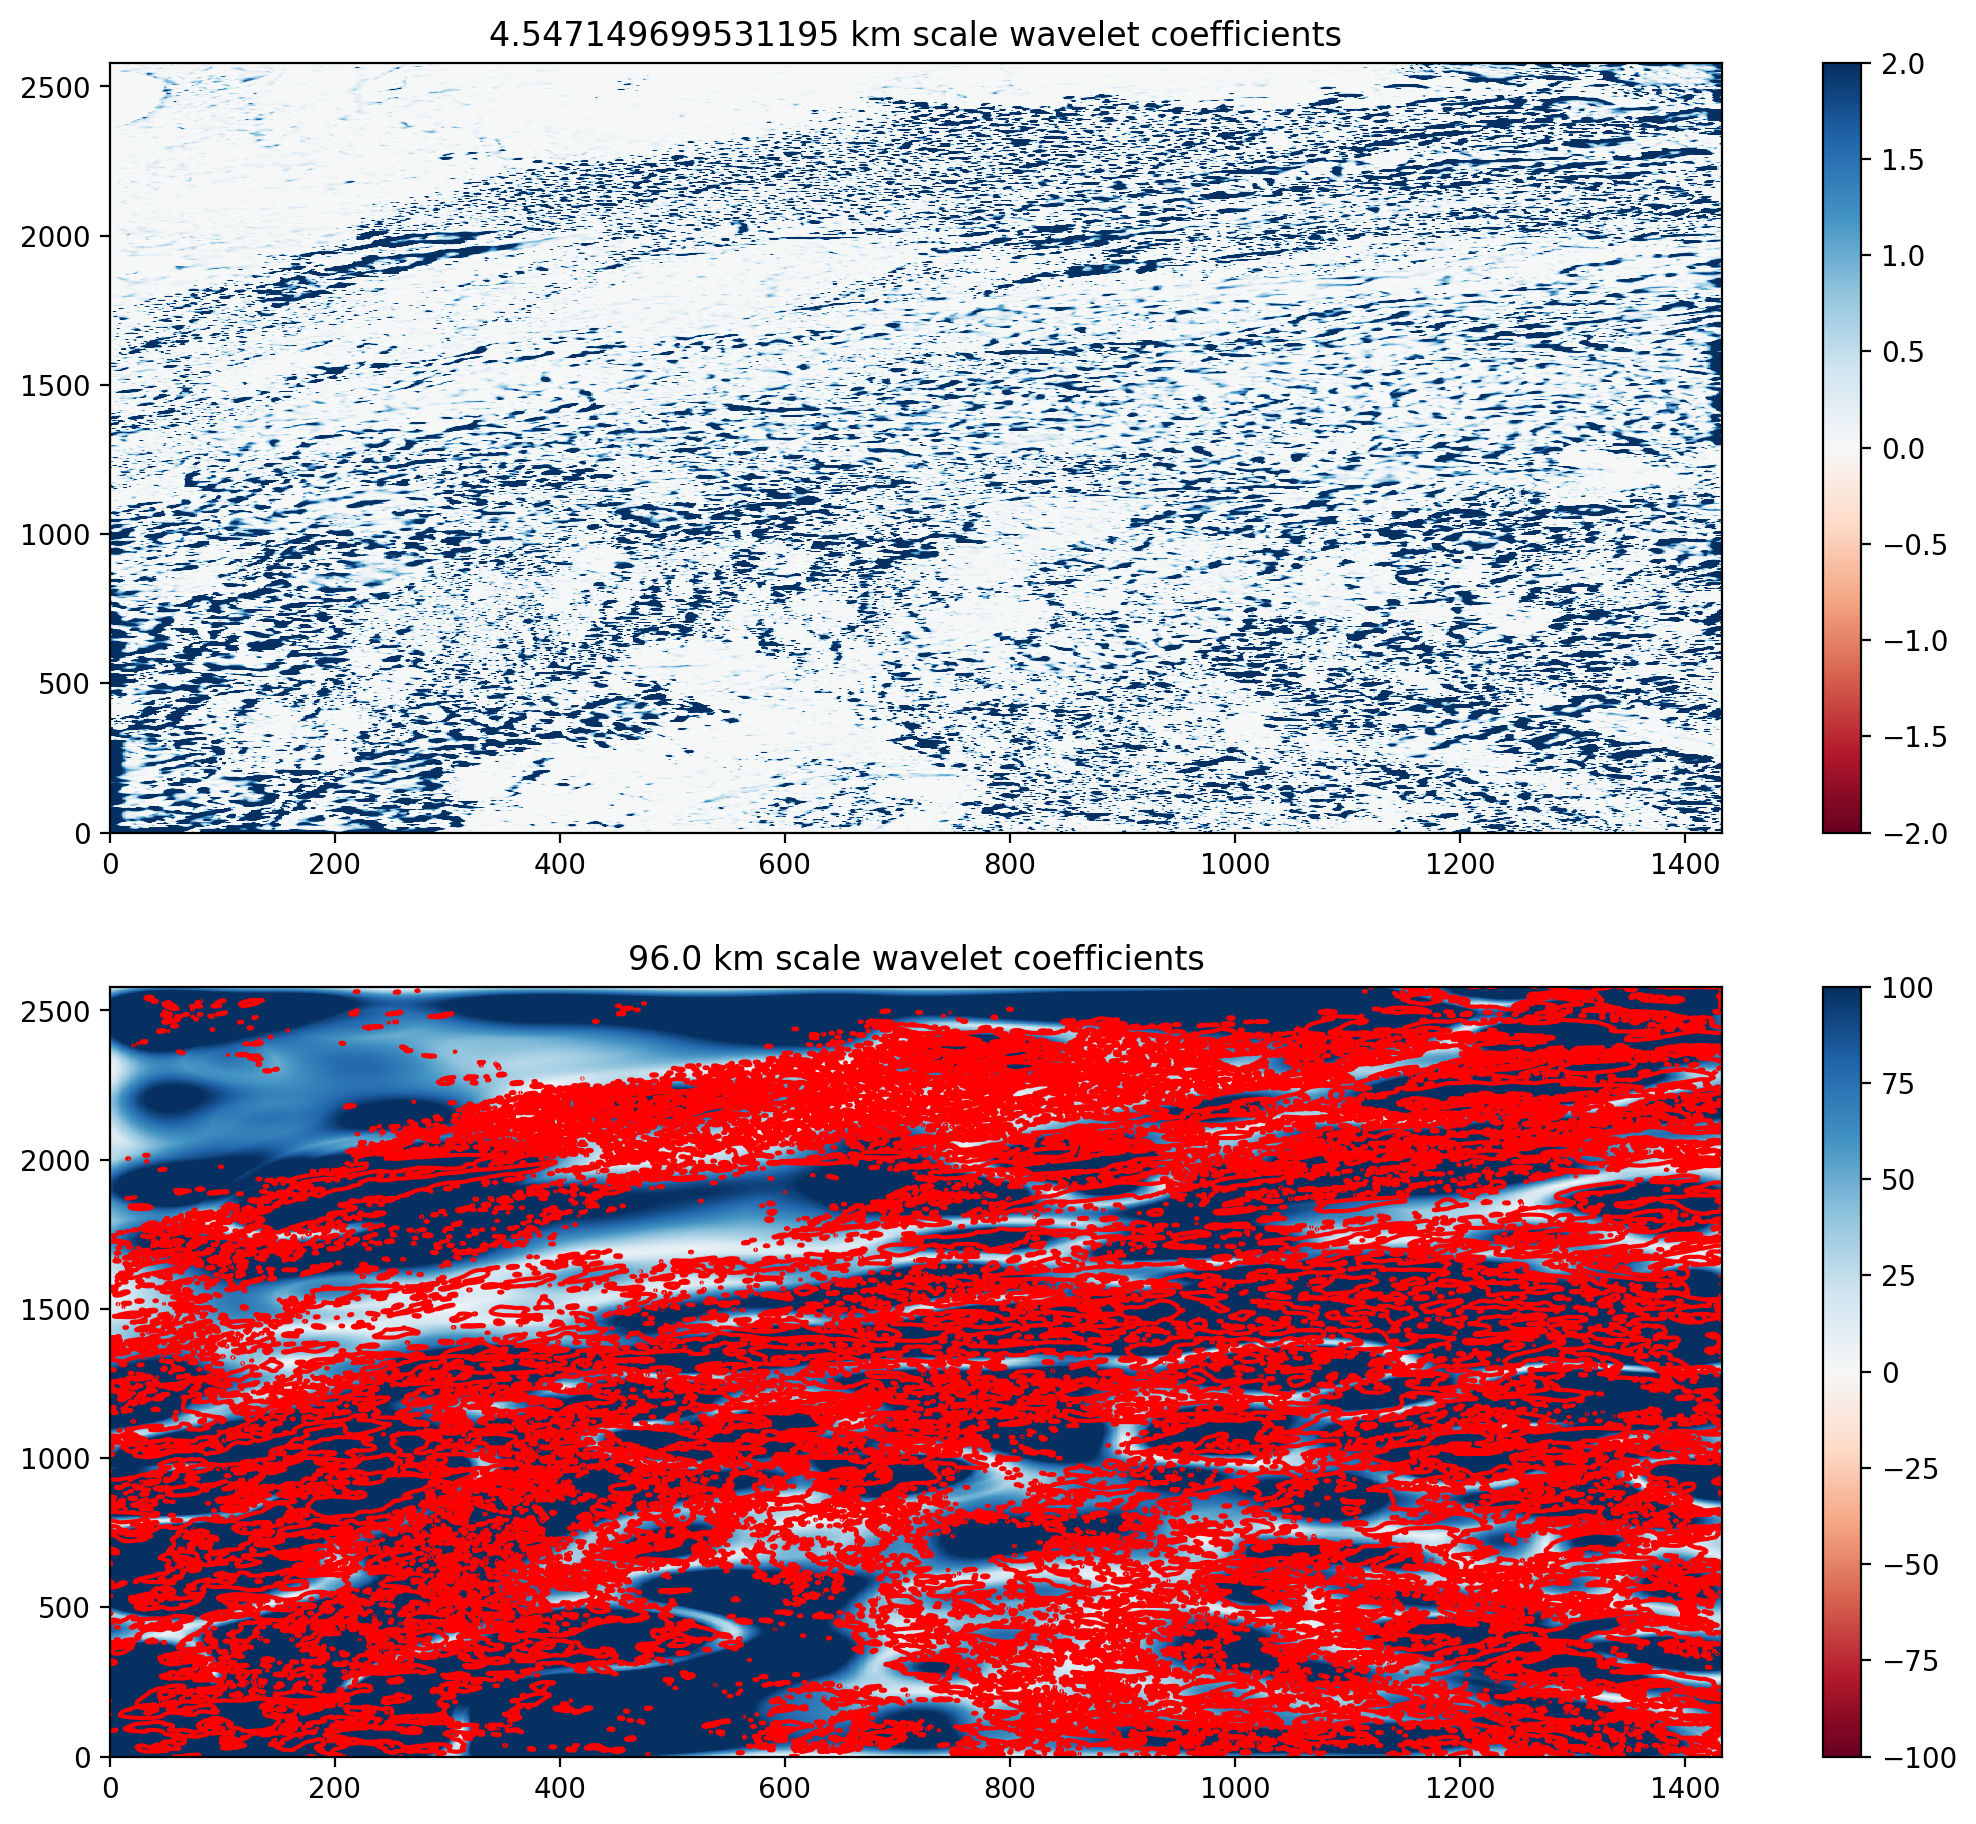

In [95]:
### This shows wavelet coefficient images of two chosen scales

f = plt.figure(figsize=(13,11), dpi=200)
ax = f.add_subplot(211)
scale_id = 4
#plt.pcolormesh(wObj.power[4,:,:], vmin=-1,vmax=1, cmap='RdBu') #np.sum(wObj.power[0:10,:,:], axis=0)
plt.pcolormesh(np.sum(wObj.power[0:6,:,:], axis=0), vmin=-2,vmax=2, cmap='RdBu') 
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')


ax = f.add_subplot(212)
scale_id = -1

plt.pcolormesh(np.sum(np.abs(wObj.coeffs[-4::,:,:]), axis=0), vmin=-100, vmax=100, cmap='RdBu')
plt.colorbar()
plt.contour(np.sum(wObj.power[0:10,:,:], axis=0), colors=['r'], levels=[0,1])

plt.title(str(wObj.scales[scale_id])+' km scale wavelet coefficients')

Text(0.5, 1.0, 'Contours: 2.0 km power on SM')

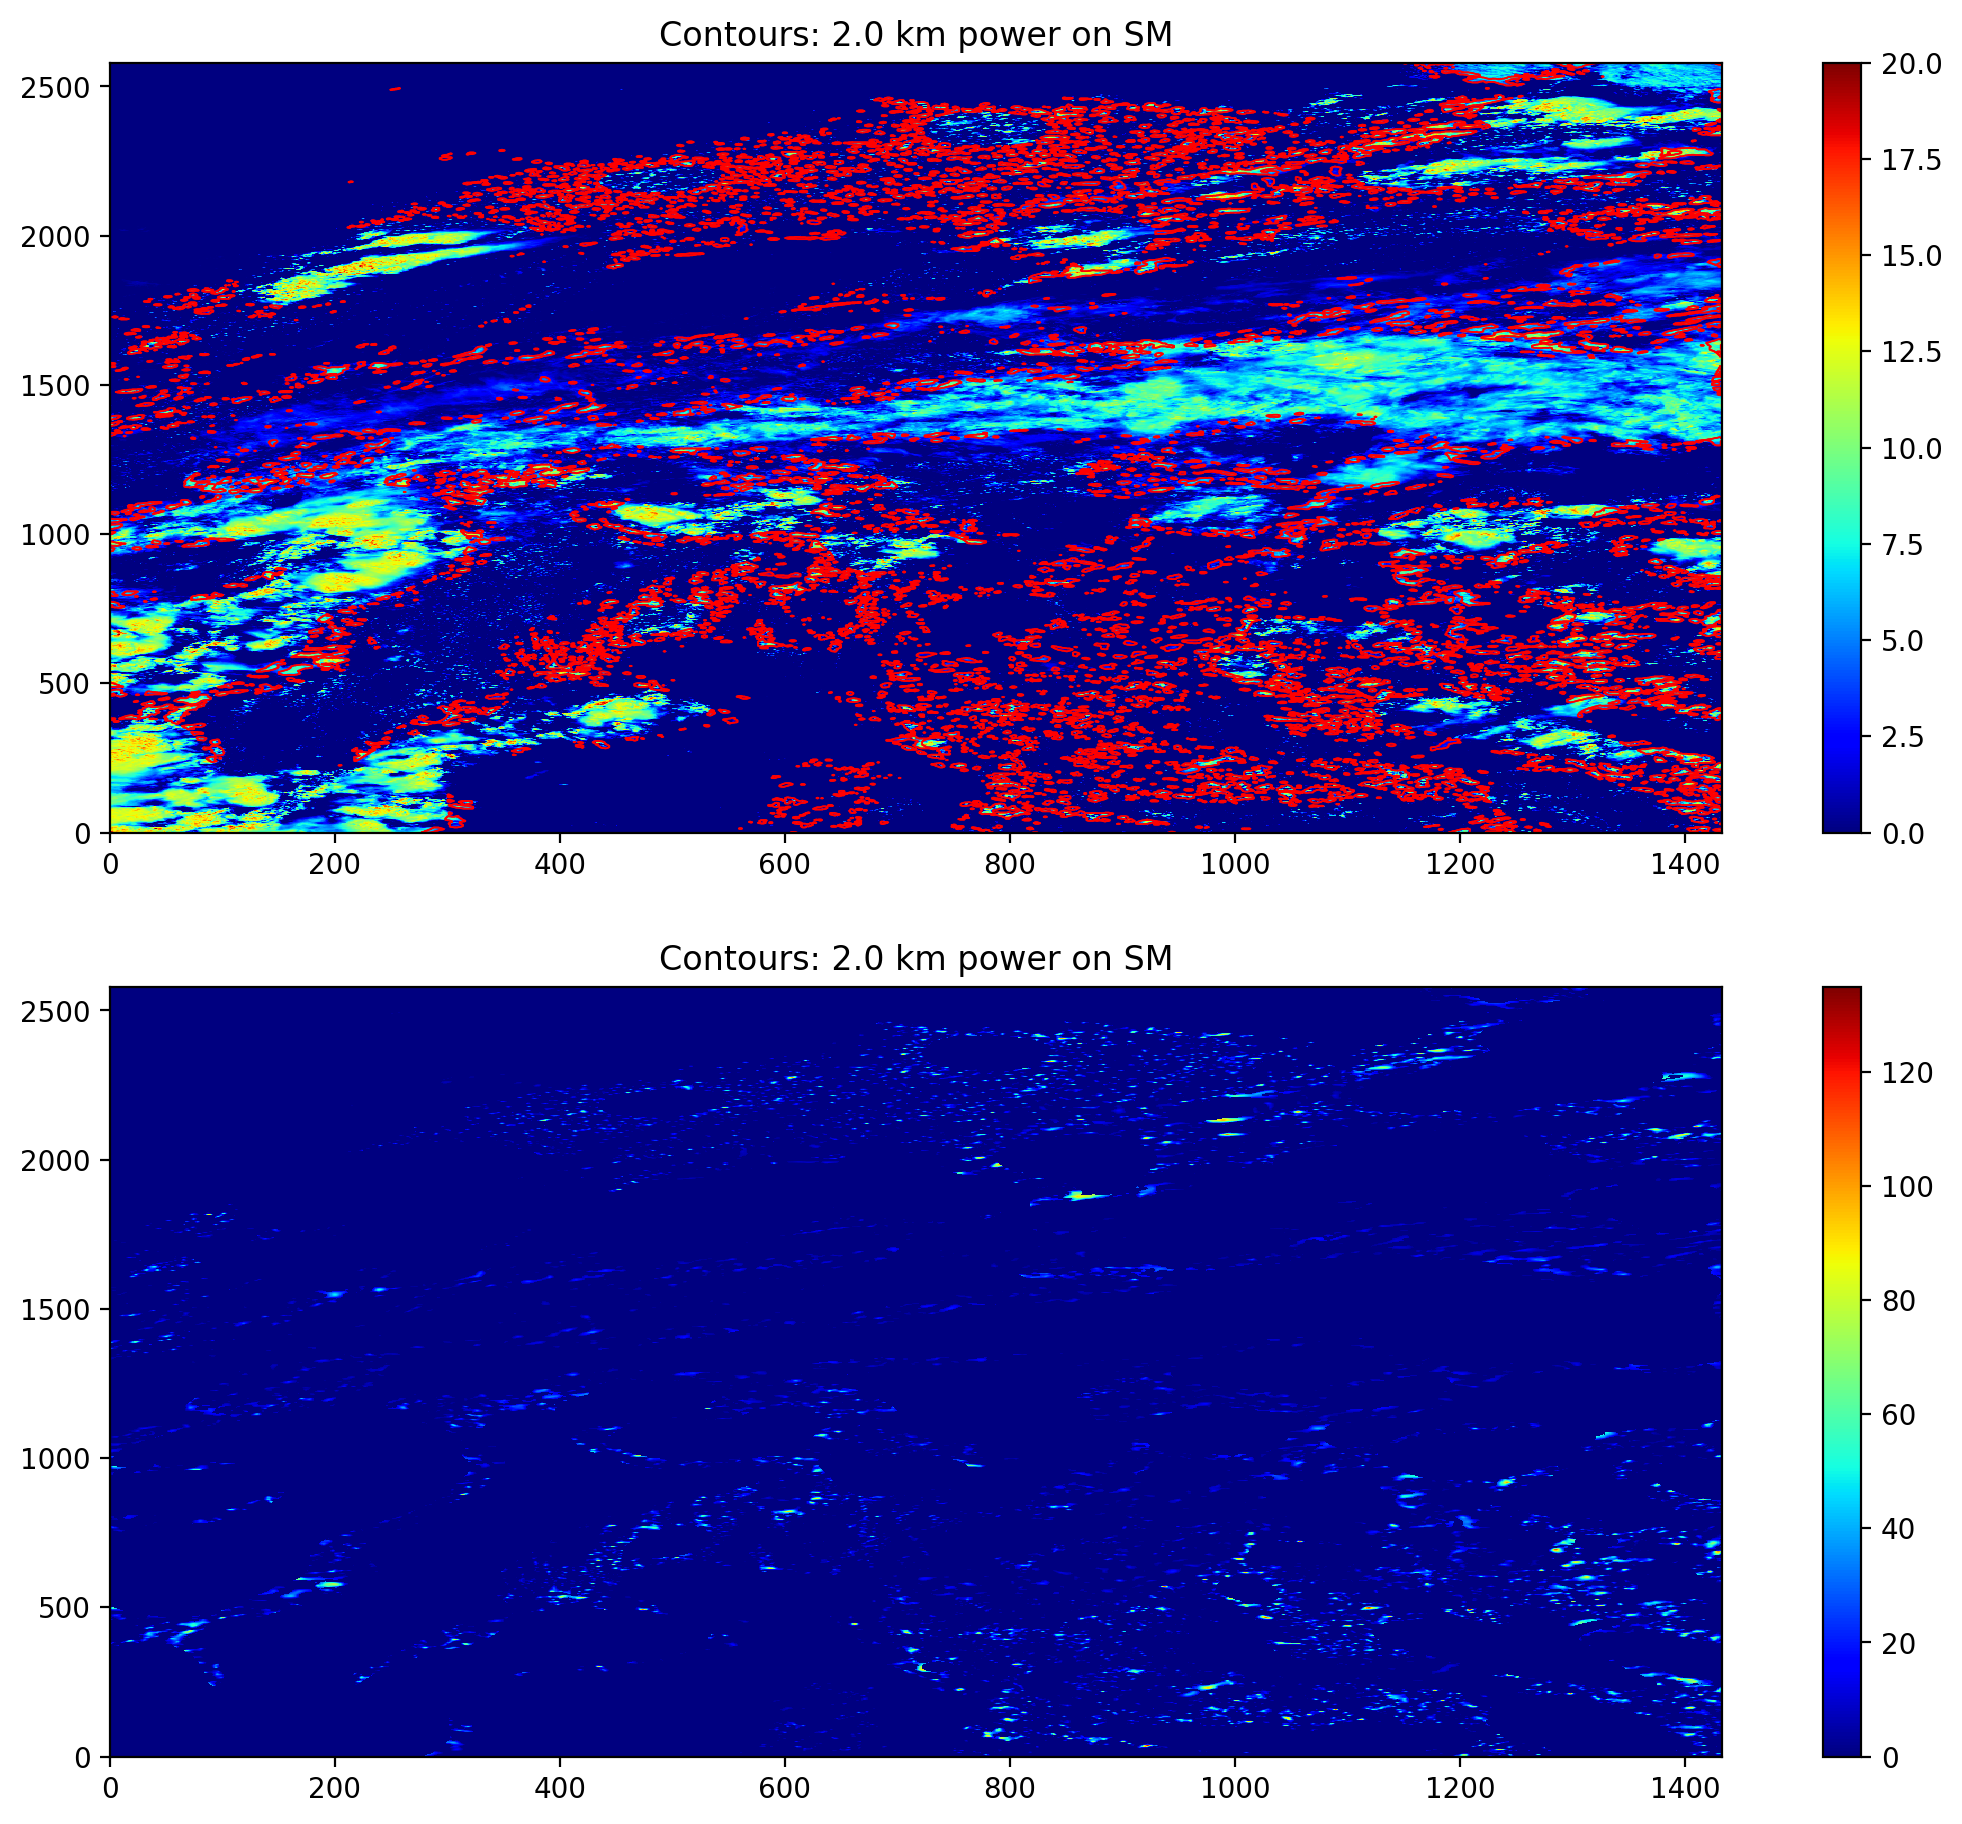

In [96]:
### Same powers as above but as contours plotted onto the SM image. 

coeffs = wObj.coeffs
coeffs_small = coeffs.copy()
coeffs_small[coeffs_small<0] = 0


f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(211)
scale_id = 2
plt.pcolormesh(wObj.image, vmax=20, vmin=0, cmap='jet')
plt.colorbar()
mask =(np.sum(wObj.coeffs[0:6,:,:], axis=0) < 0) | (np.sum(wObj.power[0:6,:,:], axis=0) < 2) | (np.sum(wObj.power[4::,:,:],axis=0)<0.25) | (np.sum(np.abs(wObj.coeffs[-4::,:,:]), axis=0) > 100)
#mask = ((np.sum(wObj.power[0:8,:,:],axis=0)<0.5) | (np.sum(wObj.power[-6::,:,:],axis=0)<0.5)) | (np.abs(wObj.coeffs[-1,:,:]) > 1)
psum = np.sum(wObj.power[:,:,:],axis=0)
psum[mask] = 0
plt.contour(psum, levels=[0,1], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')

ax = f.add_subplot(212)
scale_id = 2
plt.pcolormesh(psum, cmap='jet')
plt.colorbar()

plt.contour(wObj.power[-1,:,:], levels=[-1,10], colors=['r'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on SM')

In [97]:
bools = psum

In [98]:
bools[bools>0]=1
#bools = (bools-1)*-1
bools = bools.astype(np.uint8)

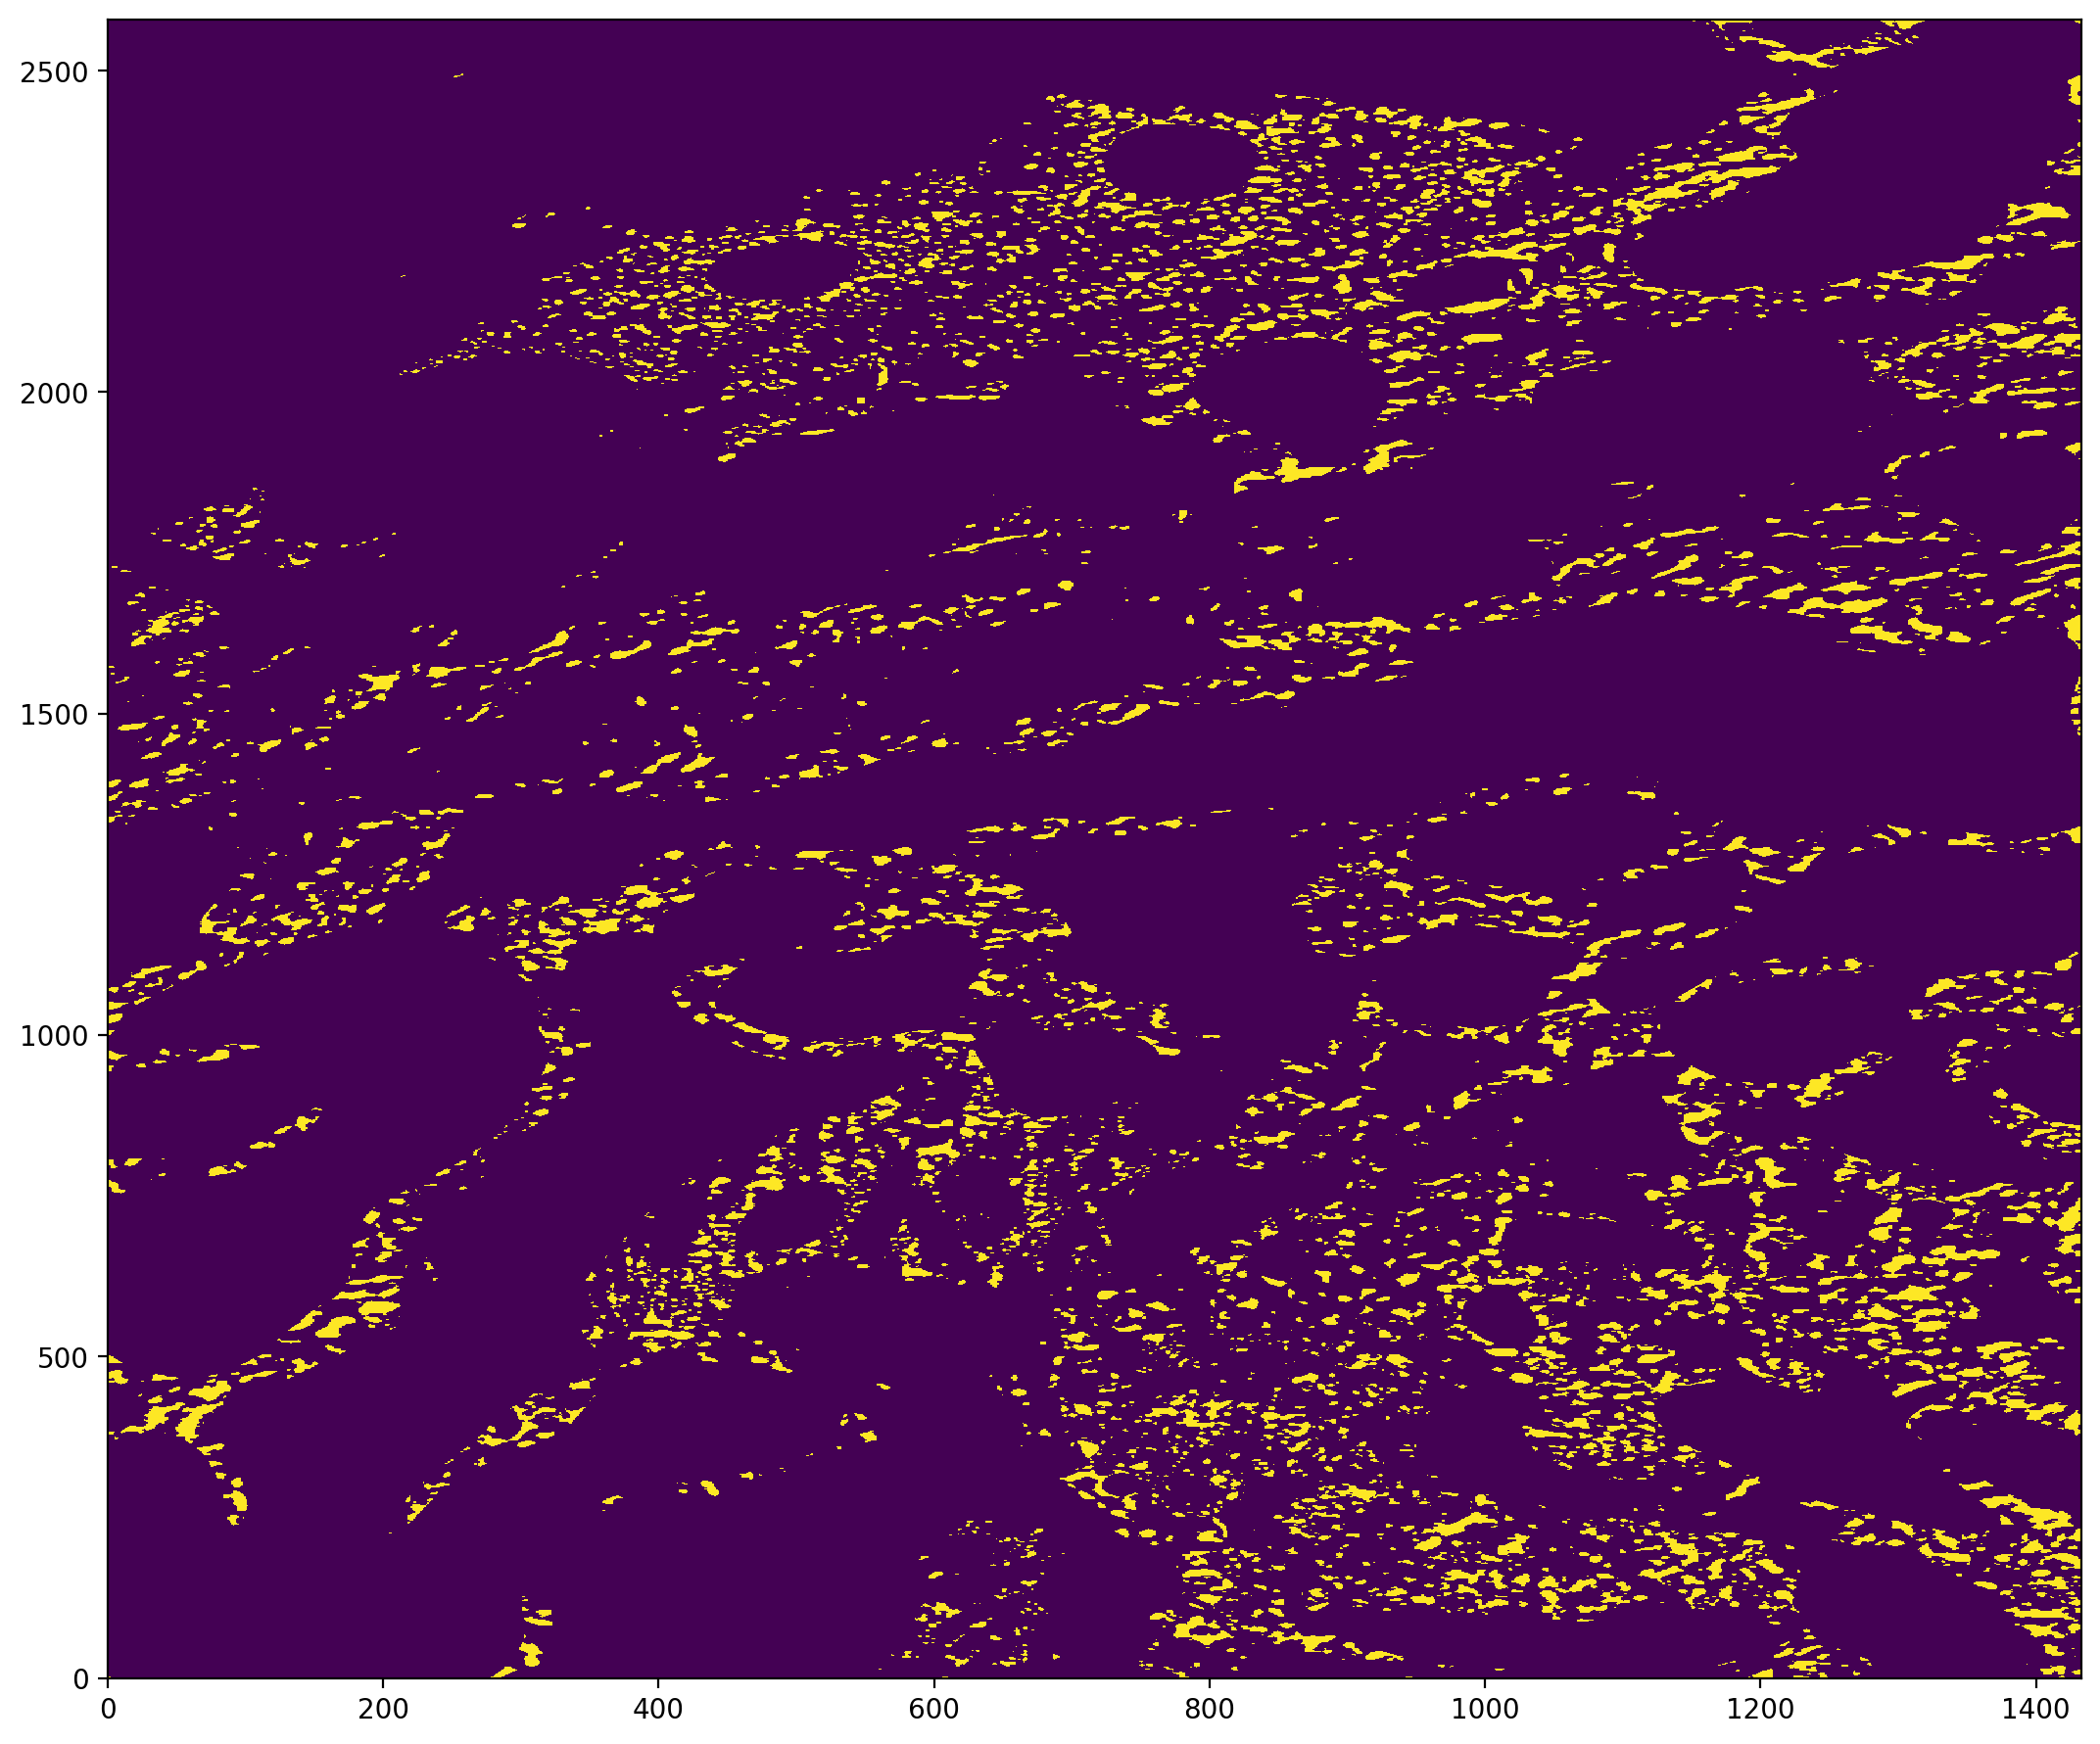

In [99]:
f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(111)
plt.pcolormesh(bools)

In [100]:
from land_wavelet import line_detection

In [101]:
merged_lines = line_detection.run_line(bools, threshold=5, minLineLength=50, maxLineGap=8)

In [106]:
merged_lines.shape

(56, 4)

In [103]:
#circles = line_detection.run_circle(bools, min_radius=5, max_radius=0)

51 376 87 455
151 533 200 601
219 246 244 302
293 369 316 420
389 516 416 571
433 675 466 741
502 2129 603 2221
591 824 598 769
594 814 633 865
665 872 671 820
683 2273 738 2269
702 2126 783 2205
711 367 714 311
788 197 814 139
843 2424 854 2358
926 2256 975 2345
950 201 991 252
992 2293 1031 2358
994 648 1019 713
1034 577 1057 522
1071 411 1122 410
1106 2265 1135 2320
1125 240 1150 224
1153 895 1169 843
1189 672 1215 600
1227 897 1279 971
1287 680 1298 731
1301 598 1325 539
1307 236 1326 180
1308 492 1410 395
1380 283 1417 206
1419 716 1426 662
1357 149 1415 93
59 441 115 476
1053 442 1104 435
1296 443 1359 483
160 549 211 580
1302 577 1357 563
979 619 1032 615
1284 622 1338 671
804 826 859 847
440 1031 491 983
223 1564 273 1574
812 1608 932 1644
1230 1665 1288 1670
608 1750 667 1776
1007 1988 1067 2042
1304 2064 1394 2109
936 2115 1012 2135
534 2168 586 2189
916 2170 1004 2224
782 2195 834 2244
775 2262 831 2282
929 2270 1043 2364
1132 2319 1201 2382
1188 2418 1238 2463


(2000.0, 2500.0)

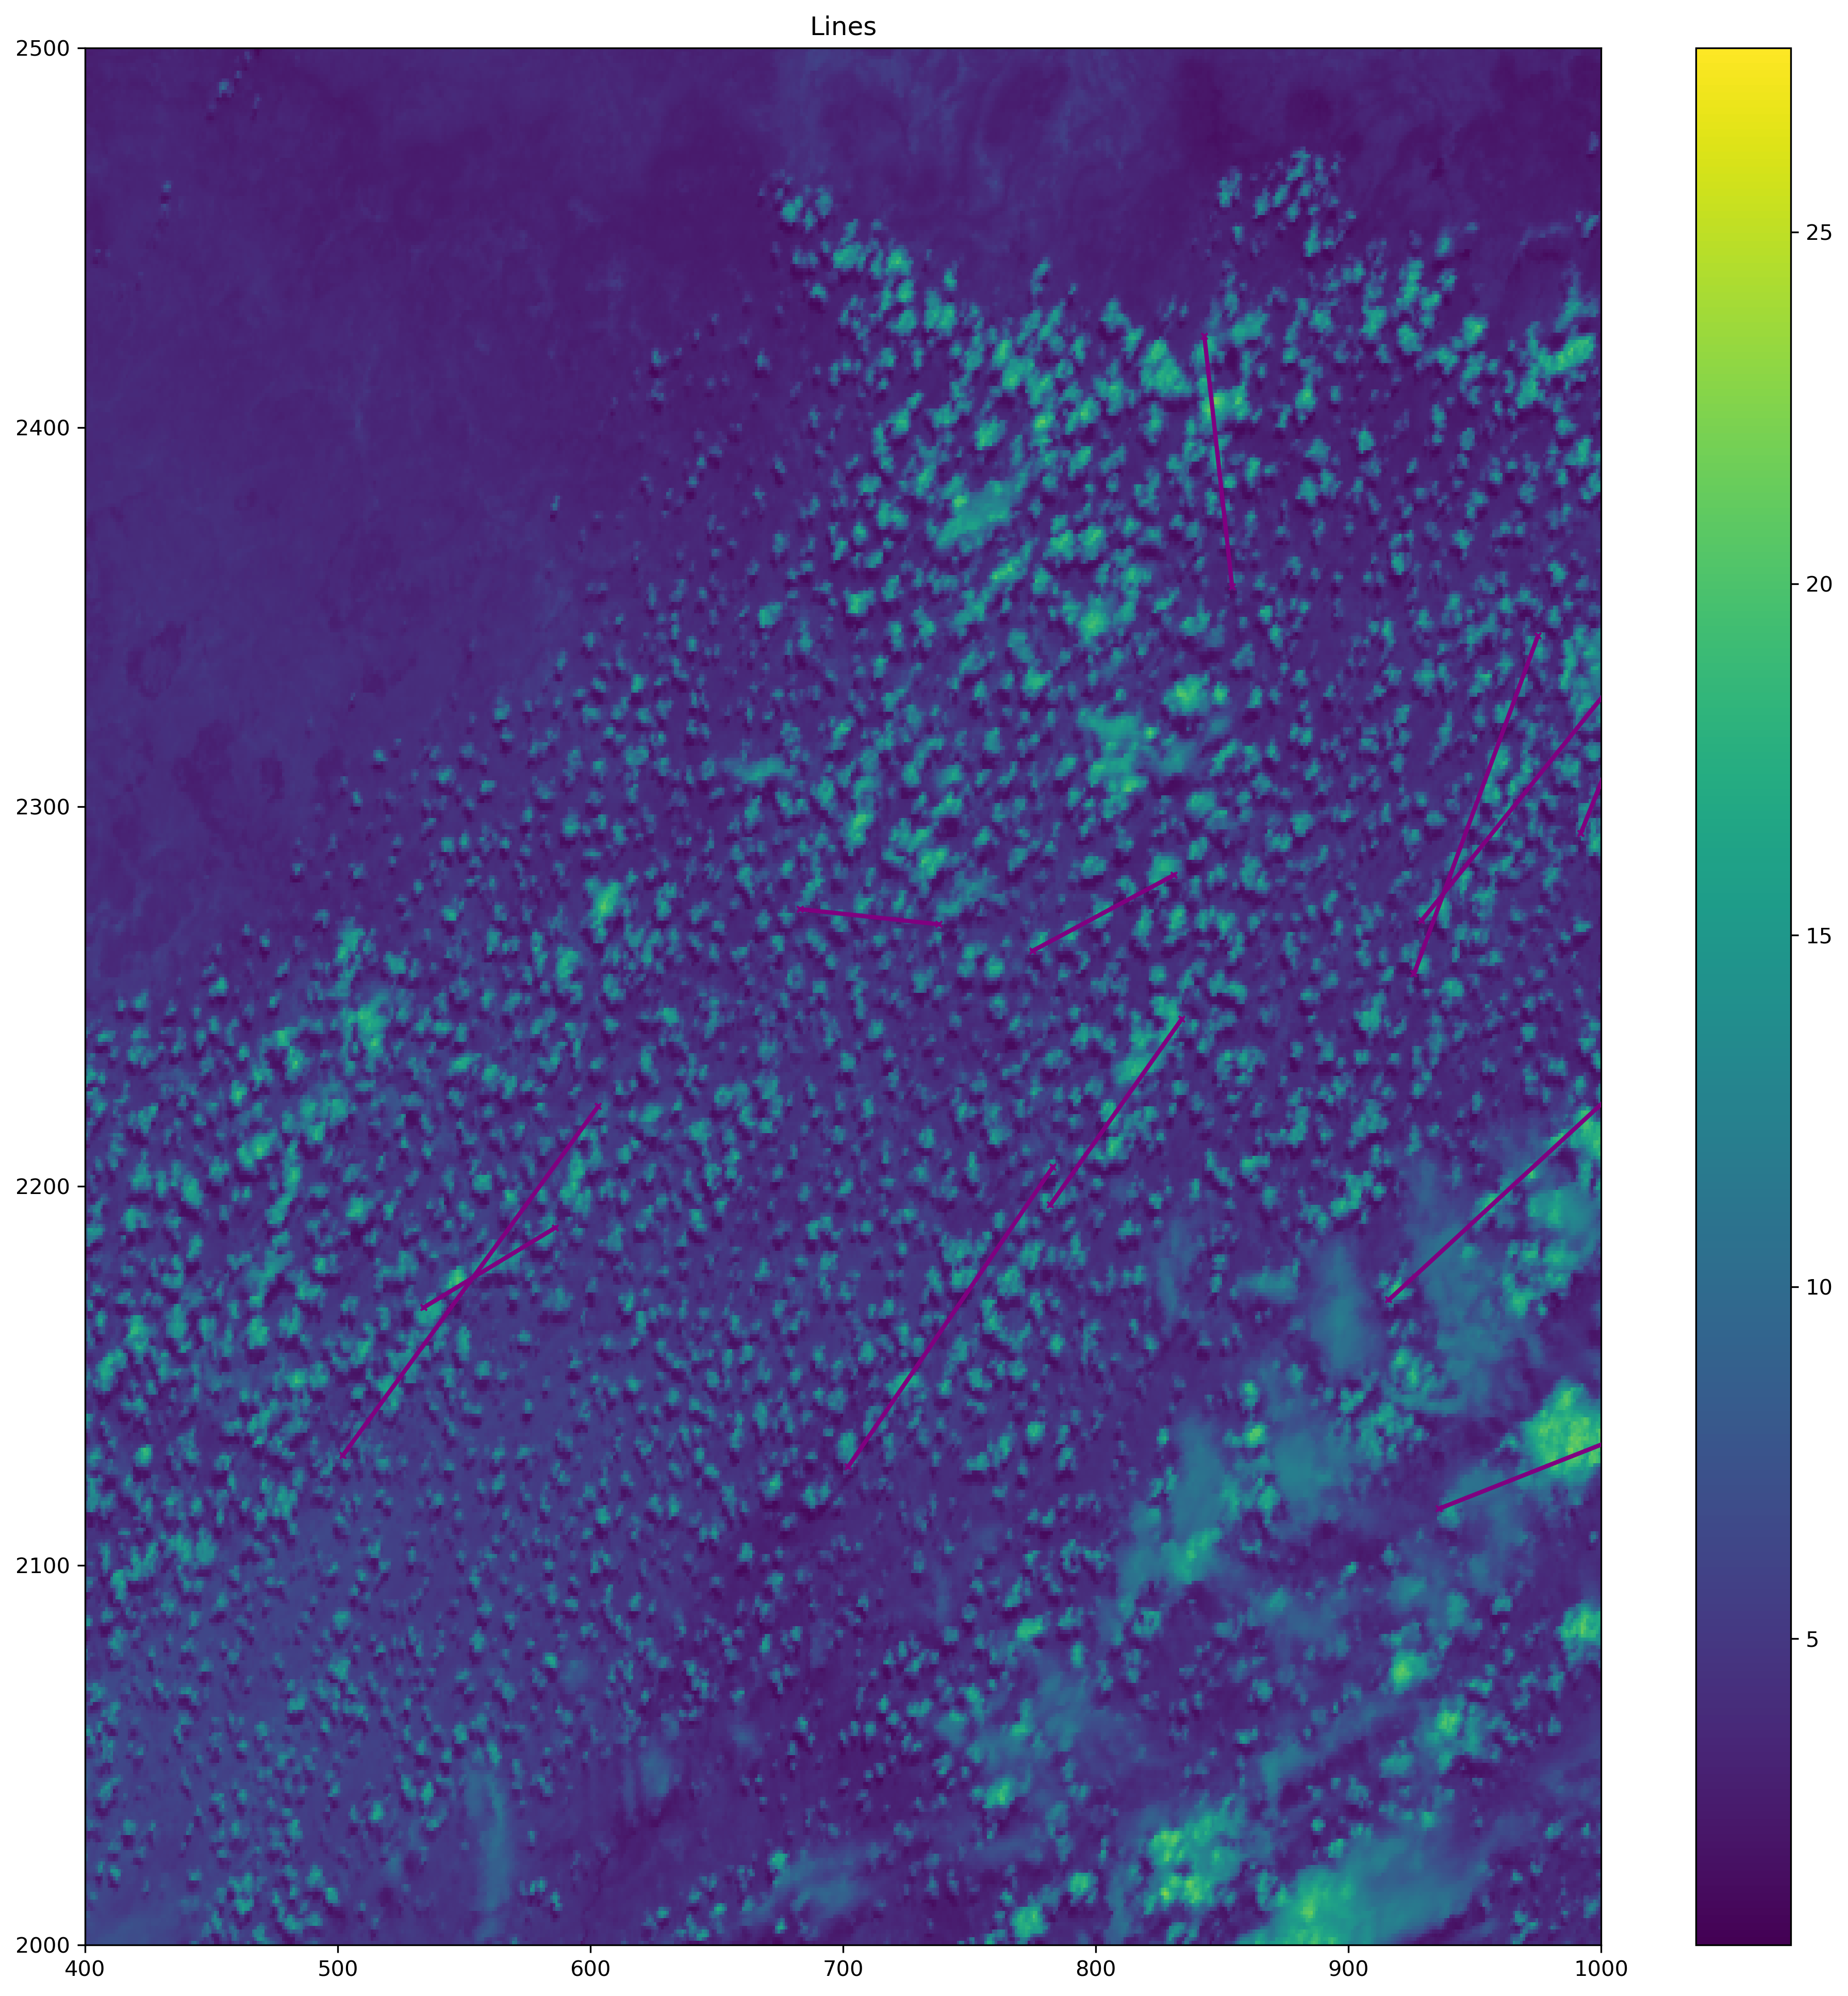

In [105]:
f = plt.figure(figsize=(13,13), dpi=300)

# ax = f.add_subplot(221)

# mp=ax.pcolormesh(bools, cmap='jet')
# plt.colorbar(mp)
# plt.title('Bools')


ax = f.add_subplot(111)

mp= ax.pcolormesh(da_box, cmap='viridis', zorder=0)
plt.colorbar(mp)
plt.title('Lines')

#for line in merged_lines:
for x1, y1, x2, y2 in merged_lines:
    print(x1, y1, x2, y2)
    
    ax.plot([x1, x2], [y1, y2], marker = 'x', markersize=3, color='purple', linestyle='solid', linewidth=2, zorder=99)
plt.tight_layout()
#f.savefig('/home/ck/Desktop/test2.png')
ax.set_xlim(400,1000)
ax.set_ylim(2000,2500)